In [1]:
!pip install opencv-python
!pip install matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

  Using cached opencv-python-4.10.0.84.tar.gz (95.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for opencv-python: filename=opencv_python-4.10.0.84-cp37-cp37m-macosx_10_16_x86_64.whl size=27422709 sha256=190a2fd07629901eabe34eaab78244c1a9bc7df242837f279df4819c94816499
  Stored in directory: /Users/jinyongyun/Library/Caches/pip/wheels/c0/b6/27/bb57a3947a27f473d0e24ca4974b4d0e16f8458f4fddc68b59
Successfully built opencv-python


width: 523 pixels
height: 184 pixels
channels: 3


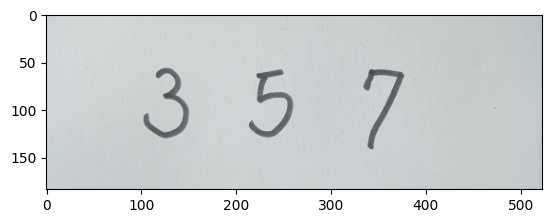

In [2]:
frame = 'digits_357.jpg'

img = cv2.imread(frame)
#plt.figure(figsize=(10,10))
plt.imshow(img);
print("width: {} pixels".format(img.shape[1]))
print("height: {} pixels".format(img.shape[0]))
print("channels: {}".format(img.shape[2]))

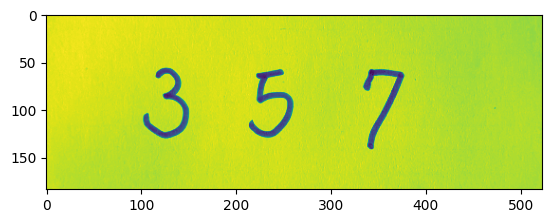

In [3]:
# hsv transform - value = gray image
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv)
plt.imshow(value)

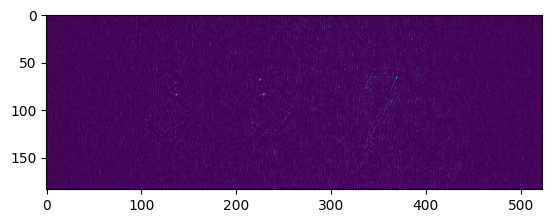

In [4]:
# kernel to use for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# applying topHat operations
topHat = cv2.morphologyEx(value, cv2.MORPH_TOPHAT, kernel)
plt.imshow(topHat)

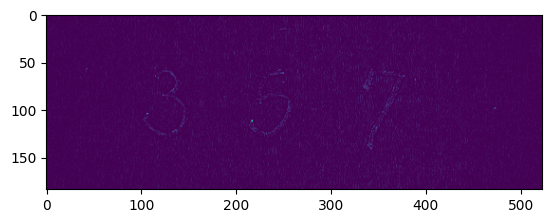

In [5]:
# applying blackHat operations
blackHat = cv2.morphologyEx(value, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackHat)

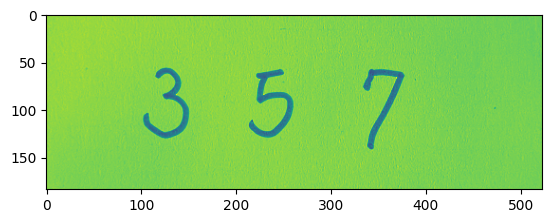

In [6]:
# add and subtract between morphological operations
add = cv2.add(value, topHat)
subtract = cv2.subtract(add, blackHat)
plt.imshow(subtract)

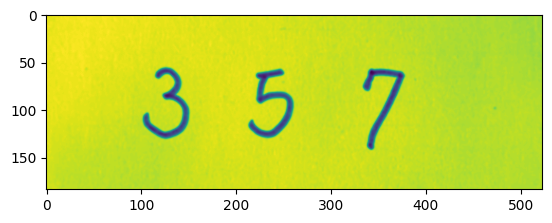

In [7]:
# applying gaussian blur on subtract image
blur = cv2.GaussianBlur(subtract, (5, 5), 0)
plt.imshow(blur)

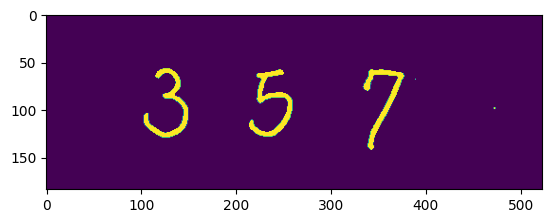

In [8]:
# thresholding
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)
plt.imshow(thresh)

In [9]:
# cv2.findCountours() function changed from OpenCV3 to OpenCV4: now it have only two parameters instead of 3
cv2MajorVersion = cv2.__version__.split(".")[0]
print('openCV version : ', cv2MajorVersion)
# check for contours on thresh
if int(cv2MajorVersion) >= 4:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
else:
    imageContours, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

openCV version :  4


334 378 58 143
214 260 58 129
103 150 57 130


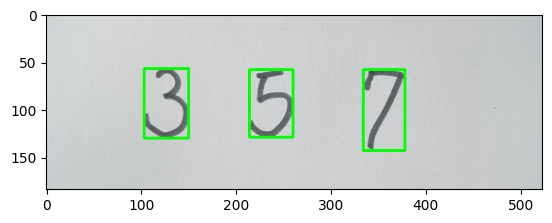

In [10]:
img_digits = []
img_origin = img.copy()
margin = 10

# loop to check if any (possible) contour is found
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  # Ignore if image is too small 이건 진짜 임시방편
  if w * h < 100: continue
  #Y and X [y-margin:y+h+margin, x-margin:x+w+margin]
  img_digits.append(img_origin[y-margin:y+h+margin, x-margin:x+w+margin])
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
  print(x,  x+w, y, y+h)
plt.imshow(img)

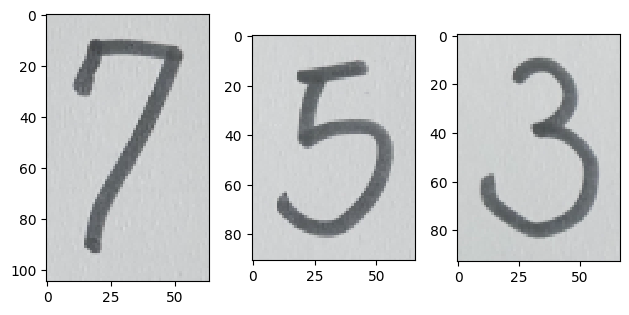

In [11]:
for i in range(0, len(img_digits)):
    plt.subplot(1, len(img_digits), i+1)
    plt.imshow(img_digits[i], cmap='Greys', interpolation='nearest')
plt.tight_layout()
plt.show() 

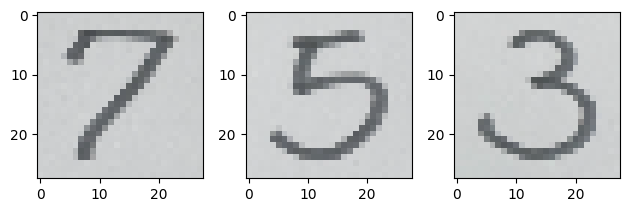

In [12]:
SZ = 28

for i in range(0, len(img_digits)):
    plt.subplot(1, len(img_digits), i+1)
    plt.imshow(cv2.resize(img_digits[i], (SZ, SZ)), cmap='Greys', interpolation='nearest')
plt.tight_layout()
plt.show() 

Load Deep Learning Model

In [13]:
import tensorflow as tf

model = tf.keras.models.load_model('digits_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


2024-12-01 23:09:37.692956: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-01 23:09:37.693610: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-12-01 23:09:37.797625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


[1.7435677e-05, 0.00036962936, 0.51301324, 0.46189535, 7.384331e-13, 0.024145726, 0.0002567719, 0.00021814842, 8.372175e-05, 5.7565194e-13]
[0.0065201134, 3.2392986e-06, 2.0053954e-05, 0.01902832, 2.0170029e-11, 0.9743603, 5.813007e-05, 9.645669e-06, 2.2520597e-07, 3.3096408e-09]
[0.0060326257, 0.00024105627, 0.044833288, 0.66302055, 2.0678938e-11, 0.28566214, 0.00012917032, 2.9496239e-06, 7.8312e-05, 1.4439773e-08]


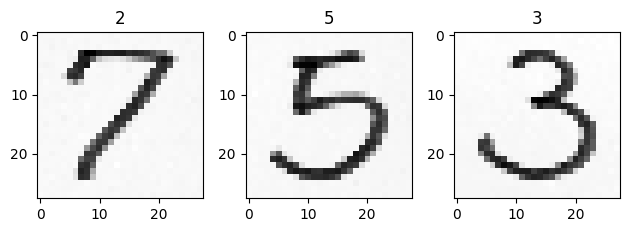

In [14]:
SZ = 28

for i in range(0, len(img_digits)):
    plt.subplot(1, len(img_digits), i+1)
    num = cv2.resize(img_digits[i], (SZ,SZ))[:,:,1]
    num = 255 - num #Reverse 
    num = num.astype('float32') / 255.
    plt.imshow(num, cmap='Greys', interpolation='nearest');
    result = model.predict(np.array([num]))
    result_number = np.argmax(result)
    plt.title(result_number)
    performance = [ val for val in result[0]]
    print(performance)
plt.tight_layout()
plt.show()